# Segmenting Binary Images
Source:
- [Segmenting Binary Images | Binary Images](https://youtu.be/2ckNxEwF5YU)

---

In [14]:
from matplotlib import pyplot as plt
from PIL import Image
import cv2 as cv
import numpy as np
import imutils
import copy

In [15]:
#Utils
def cvtBinary(path):
    image = cv.imread(path, cv.IMREAD_GRAYSCALE)
    resized = imutils.resize(image, width=SIZE)
    resized = resized.tolist()

    row, col = len(resized), len(resized[0])
    for i in range(row):
        for j in range(col):
            if(resized[i][j]!=255):
                resized[i][j] = 0
            else:
                resized[i][j] = 1
    
    return resized

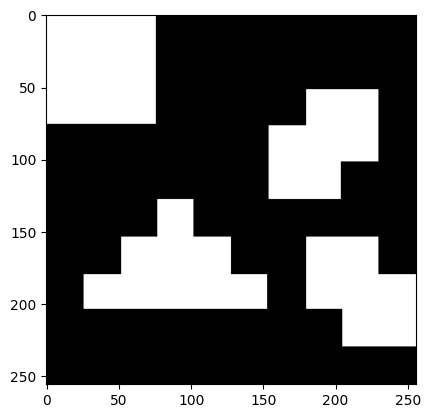

In [16]:
#Data prep
data = [[0, 0, 0, 1, 1, 1, 1, 1, 1, 1],
		[0, 0, 0, 1, 1, 1, 1, 1, 1, 1],
		[0, 0, 0, 1, 1, 1, 1, 0, 0, 1],
		[1, 1, 1, 1, 1, 1, 0, 0, 0, 1],
		[1, 1, 1, 1, 1, 1, 0, 0, 1, 1],
		[1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
		[1, 1, 0, 0, 0, 1, 1, 0, 0, 1],
		[1, 0, 0, 0, 0, 0, 1, 0, 0, 0],
		[1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
		[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]

row, col = len(data), len(data[0])
for i in range(row):
    for j in range(col):
        data[i][j] = int(not data[i][j])


image = Image.new('1', (10,10))
pixels = image.load()

for i in range(image.size[0]):
    for j in range(image.size[1]):
       pixels[j, i] = data[i][j]

image.save("data/bin0.bmp")
plt.imshow(data, cmap="gray")

#Resizing
SIZE = 256
image = cv.imread('data/bin0.bmp', cv.IMREAD_GRAYSCALE)
resized = imutils.resize(image, width=SIZE)
resized = resized.tolist()

row, col = len(resized), len(resized[0])
for i in range(row):
    for j in range(col):
        if(resized[i][j]!=255):
            resized[i][j] = 0
        else:
            resized[i][j] = 1

image = Image.new('1', (SIZE,SIZE))
pixels = image.load()

for i in range(image.size[0]):
    for j in range(image.size[1]):
       pixels[j, i] = resized[i][j]

image.save("data/bin0.bmp")
plt.imshow(resized, cmap="gray")

(8, [{3, 4}, {5, 6}, {6, 8}])

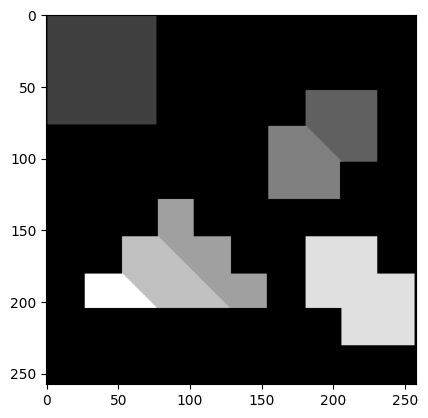

In [26]:
#Grouping

#padding
img = cvtBinary("data/bin0.bmp")
row, col = len(img), len(img[0])

for i in range(row):
    padding = [0]
    img[i] = [0] + img[i] + [0] 


padding = [0 for _ in range(SIZE+2)]
img.insert(0, padding)
img.append(padding)

#First pass
equivalence_table = []
temp = list(img)

kernel = [(0,0),(0,0)]
row, col = len(img), len(img[0])

region = 1
for i in range(row-1):
    for j in range(col-1):
        kernel = ((img[i][j], img[i][j+1])
                  ,(img[i+1][j], img[i+1][j+1]))
        
        if kernel[1][1] == 1 :
            reg = 1
            if kernel[0] == (0,0) and kernel[1] == (0,1):
                reg = region+1
                region+=1

            elif kernel[0][0] != 0 :
                reg = kernel[0][0]
            
            elif kernel[0] == (0,0):
                reg = kernel[1][0]
            
            elif kernel[0][0] == 0 and kernel[1][0] == 0:
                reg = kernel[0][1]
            
            elif kernel[0][0] == 0 and kernel[0][1] == kernel[1][0]:
                reg = kernel[1][0]
            
            elif kernel[0][0] == 0 and kernel[0][1] != kernel[1][0]:
                if {kernel[0][1], kernel[1][0]} not in equivalence_table:
                    equivalence_table.append({kernel[0][1], kernel[1][0]})

                reg = kernel[1][0]
            
            temp[i+1][j+1] = reg

plt.imshow(temp, cmap="gray")
region, equivalence_table


In [27]:
#Dealing with the equivalence relations

#Absorb any overlapping sets
n = len(equivalence_table)
while True: #Assume there is overlap
    overlap = False    

    i= 0
    while i < n:
        j = 0
        while j < n:
            if len(equivalence_table[i].intersection(equivalence_table[j]))>0 and i!=j:
                overlap = True
                equivalence_table[i] = equivalence_table[i].union(equivalence_table[j])
                equivalence_table.pop(j)
                n-=1
            j+=1
        i+=1

    if not overlap:
        break


code_table={}
region_table=[]
for i in range(len(equivalence_table)):
    key = min(equivalence_table[i])
    region_table.append(key)
    for j in equivalence_table[i]:
        code_table[j] = key

#For convenience later
keys = code_table.keys()

for i in range(2, region):
    if i not in keys:
        region_table.append(i)
        code_table[i] = i
code_table[0] = 0 #Default values
code_table[1] = 1 #Default values

code_table, region_table

({3: 3, 4: 3, 8: 5, 5: 5, 6: 5, 2: 2, 7: 7, 0: 0, 1: 1}, [3, 5, 2, 7])

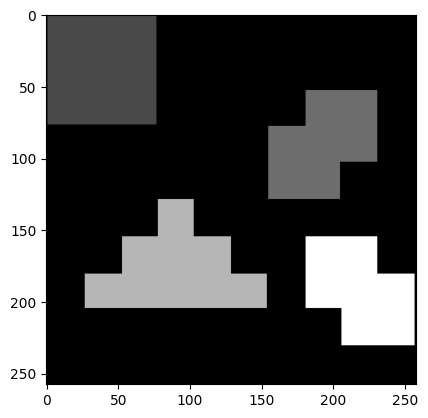

In [28]:
#Apply equivalence relations
row, col = len(temp), len(temp[0])
for i in range(row):
    for j in range(col):
        temp[i][j] = code_table[temp[i][j]]

plt.imshow(temp, cmap="gray")

In [30]:
#Regions translation
region_table = sorted(region_table)
regions = {}
for i in range(len(region_table)):
    regions[i] = region_table[i]

regions

{0: 2, 1: 3, 2: 5, 3: 7}

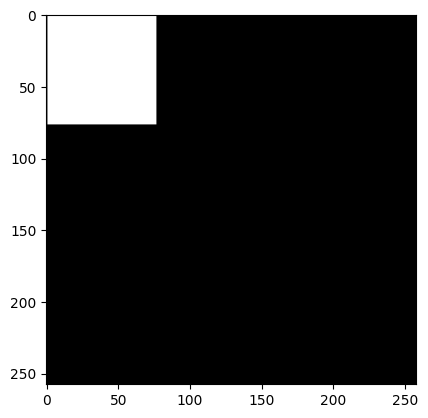

In [31]:
#"Masking"
r = 4 #Counting from zero
temp2 = copy.deepcopy(temp)
row, col = len(temp2), len(temp2[0])

r%=len(regions)
for i in range(row):
    for j in range(col):
        if(temp2[i][j]==regions[r]):
            temp2[i][j] = 1
        else:
            temp2[i][j] = 0

plt.imshow(temp2, cmap="gray")